In [1]:
import pandas as pd
import numpy as np
import datetime

%load_ext autoreload

In [2]:
from charts import plot_line
from charts import plot_bar
from features import add_variables_covid
from features import add_variables_apple

%matplotlib inline

# World Bank Data

In [45]:
import world_bank_data as wb
pd.set_option('display.max_rows', 6)

In [93]:
countries = wb.get_countries()

In [105]:
# population = wb.get_series('SP.POP.TOTL', mrv=1)  # Most recent value
population = wb.get_series('SP.POP.TOTL', id_or_value='id', simplify_index=True, mrv=1)
population

Country
ARB    419790588.0
CSS      7358965.0
CEB    102511922.0
          ...     
YEM     28498687.0
ZMB     17351822.0
ZWE     14439018.0
Name: SP.POP.TOTL, Length: 264, dtype: float64

In [112]:
# Aggregate region, country and population
df_population = countries[['region', 'name']].rename(columns={'name': 'country'}).loc[countries.region != 'Aggregates']
df_population['population'] = population
df_population.head(1)

,region,country,population
id,,,
ABW,Latin America & Caribbean,Aruba,105845.0


In [3]:
def apple_filter_region(df, region):
    df_region = df[df.region == region].T
    df_region.columns = df_region.loc['transportation_type', :]
    df_region = df_region[~df_region.index.isin(['geo_type', 'region', 'transportation_type'])]
    
    df_region['date'] = pd.to_datetime(df_region.index)
    df_region.set_index('date', inplace=True)
    df_region = df_region.astype('float')
    
    return df_region

In [4]:
date_apple = '2020-04-25'
date_now = datetime.datetime.strftime(datetime.datetime.utcnow(), "%Y-%m-%d")

dfapple = pd.read_csv(f"data/AppleMobilty/applemobilitytrends-{date_apple}.csv")

dfcovid_conf = pd.read_csv("data/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
dfcovid_dead = pd.read_csv("data/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")

df_germany = pd.read_csv("data/RKI-reports.csv")

### Add index to RKI data

In [5]:
df_germany['date'] = df_germany['date'].astype('datetime64[ns]')
df_germany = df_germany.sort_values('date', ascending=True)
df_germany.set_index('date', inplace=True)

### Transpose Confirmed Cases

In [6]:
dfcovid_conf_t = dfcovid_conf.T
dfcovid_conf_t.columns = dfcovid_conf_t.loc['Country/Region', :] + "_" + dfcovid_conf_t.loc['Province/State', :].astype(str)

dfcovid_conf_t.drop(['Country/Region'], axis=0, inplace=True)

df_country_coords = dfcovid_conf_t.loc[['Lat', 'Long'], :]

dfcovid_conf_t.drop(['Lat', 'Long', 'Province/State'], axis=0, inplace=True)
dfcovid_conf_t['dates'] = dfcovid_conf_t.index
dfcovid_conf_t['dates'] = dfcovid_conf_t['dates'].astype('datetime64[ns]')
dfcovid_conf_t = dfcovid_conf_t.sort_values('dates', ascending=True)
dfcovid_conf_t.set_index('dates', inplace=True)
dfcovid_conf_t = dfcovid_conf_t.astype(float)

### Transpose Dead Cases

In [7]:
dfcovid_dead_t = dfcovid_dead.T
dfcovid_dead_t.columns = dfcovid_dead_t.loc['Country/Region', :] + "_" + dfcovid_dead_t.loc['Province/State', :].astype(str)
dfcovid_dead_t.drop(['Country/Region'], axis=0, inplace=True)


dfcovid_dead_t.drop(['Lat', 'Long', 'Province/State'], axis=0, inplace=True)
dfcovid_dead_t['dates'] = dfcovid_dead_t.index
dfcovid_dead_t['dates'] = dfcovid_dead_t['dates'].astype('datetime64[ns]')
dfcovid_dead_t = dfcovid_dead_t.sort_values('dates', ascending=True)
dfcovid_dead_t.set_index('dates', inplace=True)
dfcovid_dead_t = dfcovid_dead_t.astype(float)


In [8]:
# import inspect
# source_DF = inspect.getsource(add_weekday_weekend)
# print(source_DF)

### Check max dates in index

In [10]:
print("Mobility max date:", max(dfapple_region.index))
print("Covi world max date", max(dfcovid_conf_t.index))
print("Covi world max date", max(dfcovid_dead_t.index))
print("RKI max date", max(df_germany.index))

Mobility max date: 2020-04-25 00:00:00
Covi world max date 2020-04-26 00:00:00
Covi world max date 2020-04-26 00:00:00
RKI max date 2020-04-26 00:00:00


### Add weekend Column

# Apple Mobility DF

## Transpose Mobility and Filter Region Create lagged and % variables

In [11]:
dfapple_region = apple_filter_region(dfapple, "Hamburg").copy()
dfapple_region = add_variables_apple(dfapple_region)

In [12]:
dfapple_region.tail(3).T

date,2020-04-23,2020-04-24,2020-04-25
transportation_type,,,
driving,73.160000,67.720000,59.680000
transit,65.160000,60.880000,58.610000
walking,71.530000,65.290000,69.390000
transit_avg3,63.000000,63.000000,61.000000
walking_avg3,67.000000,69.000000,68.000000
driving_avg3,72.000000,71.000000,67.000000
transit_l1,60.860000,65.160000,60.880000
walking_l1,66.700000,71.530000,65.290000
driving_l1,71.830000,73.160000,67.720000


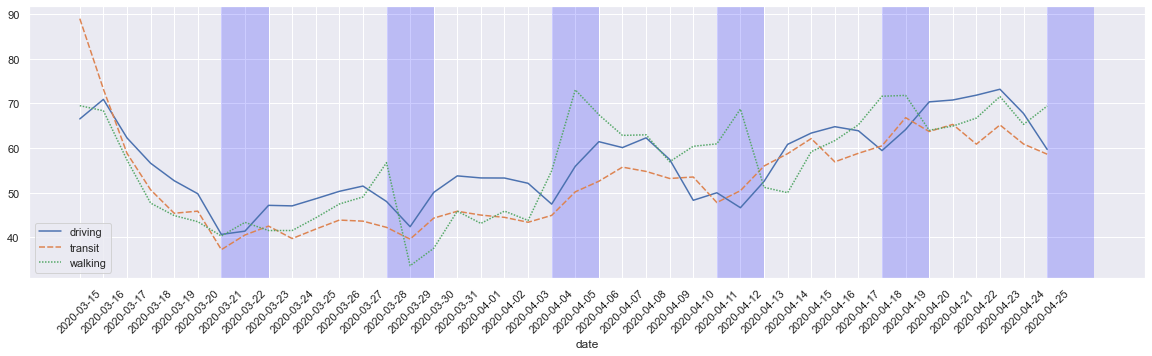

In [13]:
plot_line(dfapple_region, columns=['driving','transit','walking'], date_cutoff='2020-03-15')

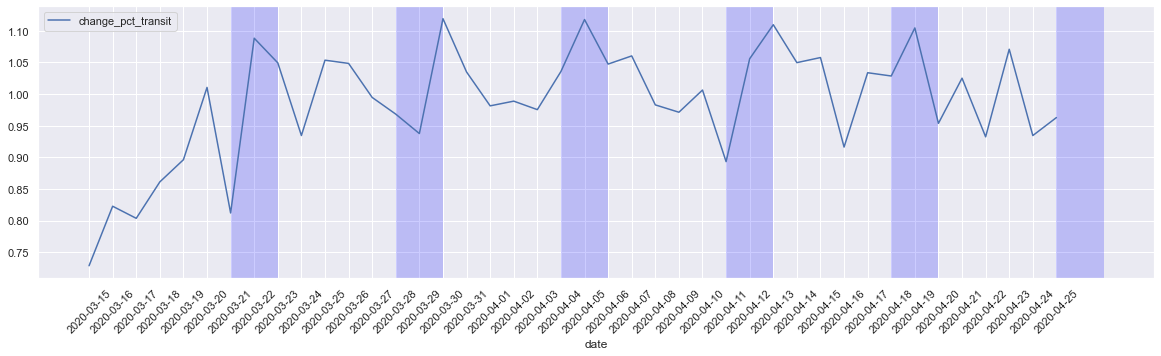

In [14]:
plot_line(dfapple_region, columns=['change_pct_transit'], date_cutoff='2020-03-15')

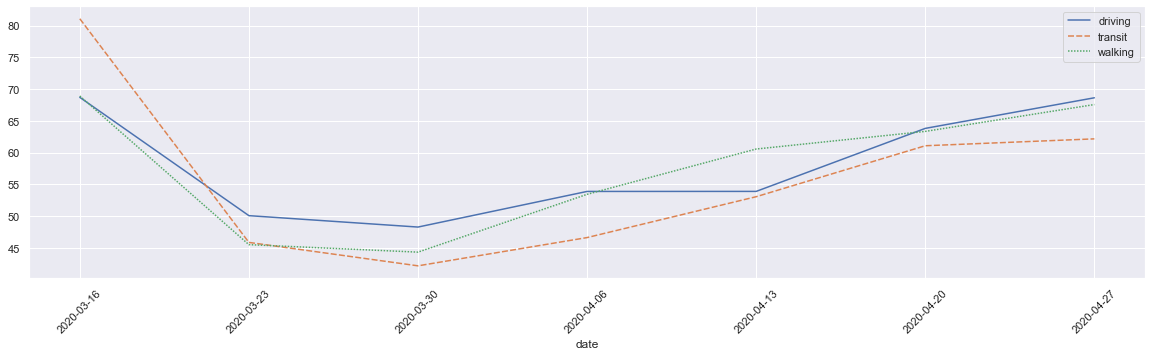

In [15]:
plot_line(dfapple_region, columns=['driving','transit','walking'], resample='W-MON', date_cutoff='2020-03-15')

# Robert Koch Institute DF

## Filter region (Hamburg)

In [16]:
df_hamburg = df_germany.loc[df_germany.land == 'Hamburg', :].copy()
df_hamburg.drop('data', axis=1, inplace=True)

## Create lagged and % variables

In [17]:
df_hamburg = add_variables_covid(df_hamburg, 'confirmed')
# df_hamburg = add_variables(df_hamburg, 'dead')

----

In [18]:
df_hamburg.sort_index(ascending=False).head().T

date,2020-04-26,2020-04-25,2020-04-24,2020-04-23,2020-04-22
land,Hamburg,Hamburg,Hamburg,Hamburg,Hamburg
confirmed,4429,4400,4358,4286,4204
dead,140,139,122,113,91
dow,6,5,4,3,2
weekend,True,True,False,False,False
confirmed_avg3,4397,4350,4284,4224,4199
confirmed_change,29,42,72,82,0
confirmed_change_avg3,46,67,59,25,14
confirmed_change_3w,1484,1703,1762,1880,1893
confirmed_change_pct,0.007,0.01,0.017,0.02,0


# Explore Plots

# Hamburg

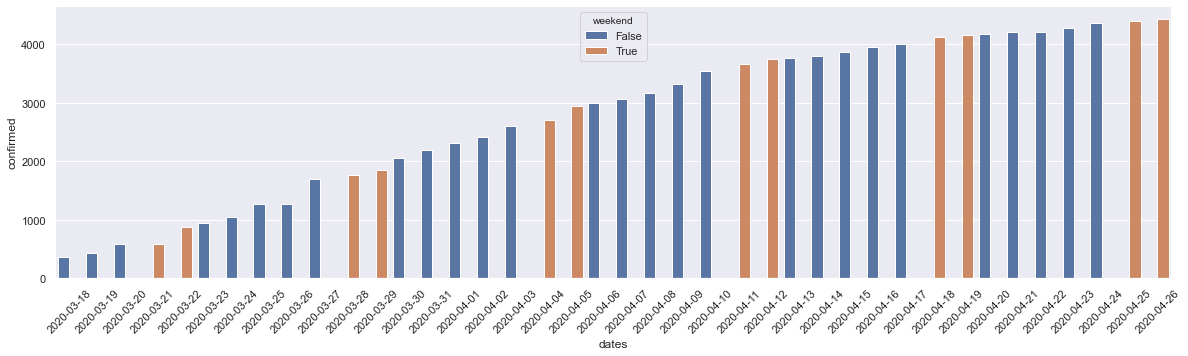

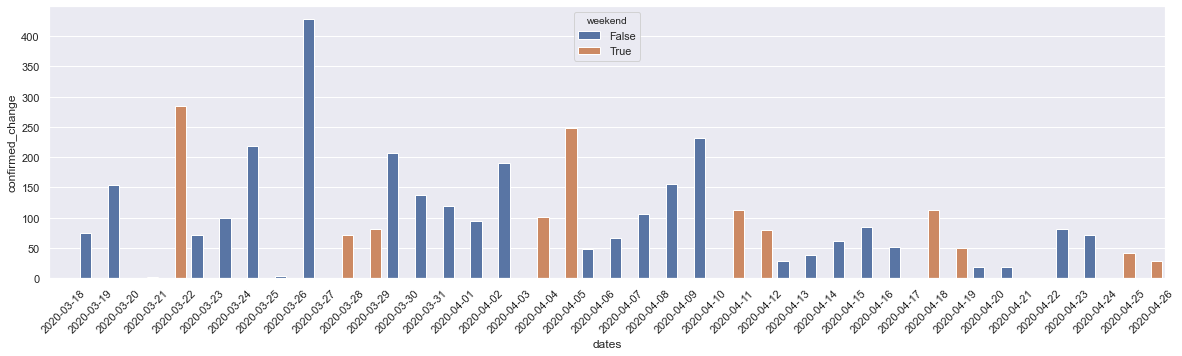

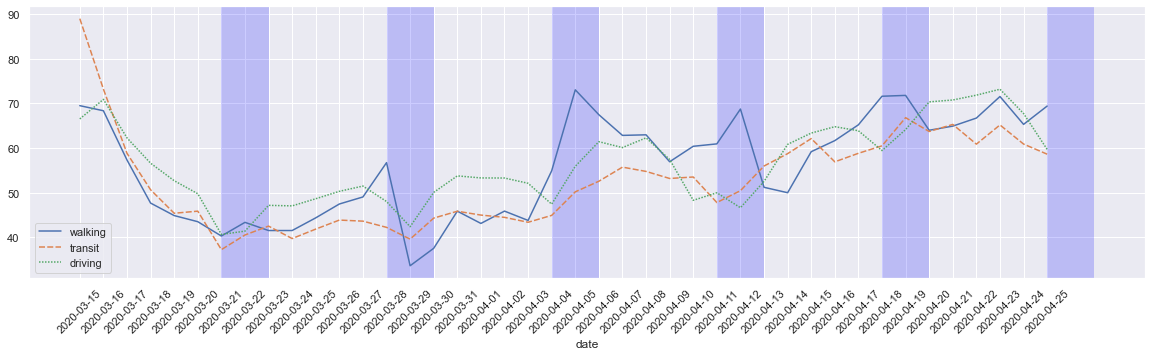

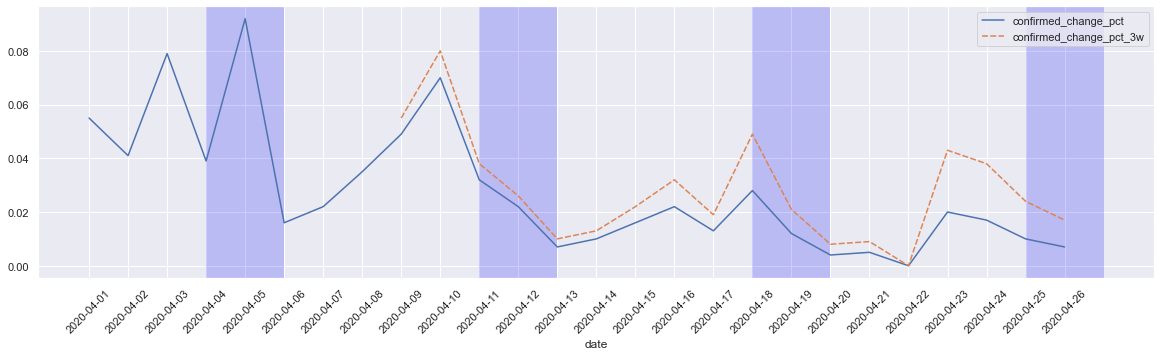

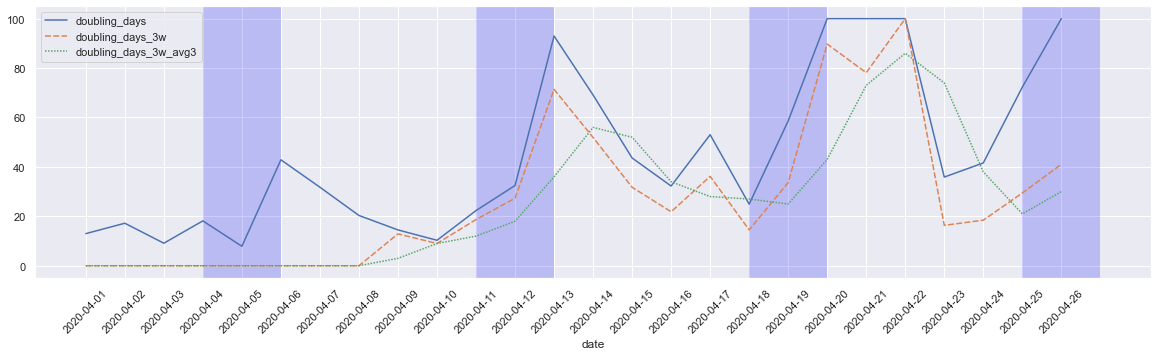

In [27]:
plot_bar(df_hamburg, columns='confirmed', date_cutoff='2020-03-15')
plot_bar(df_hamburg, columns='confirmed_change', date_cutoff='2020-03-15')
plot_line(apple_filter_region(dfapple, "Hamburg"), columns=['walking', 'transit','driving'], date_cutoff='2020-03-15')
dfapple_region = add_variables_apple(dfapple_region)
plot_line(df_hamburg, columns=['confirmed_change_pct', 'confirmed_change_pct_3w'], date_cutoff='2020-04-01')
plot_line(df_hamburg, columns=['doubling_days', 'doubling_days_3w', 'doubling_days_3w_avg3'], date_cutoff='2020-04-01')
# plot_line(df_hamburg, columns=['confirmed_change_acceleration_avg3'], date_cutoff='2020-04-01')

---

# Russia

In [20]:
df_russia = dfcovid_conf_t.loc[dfcovid_conf_t.index >= '2020-03-15', ['Russia_nan']]
df_russia.columns = ['confirmed']
df_russia = add_variables_covid(df_russia)

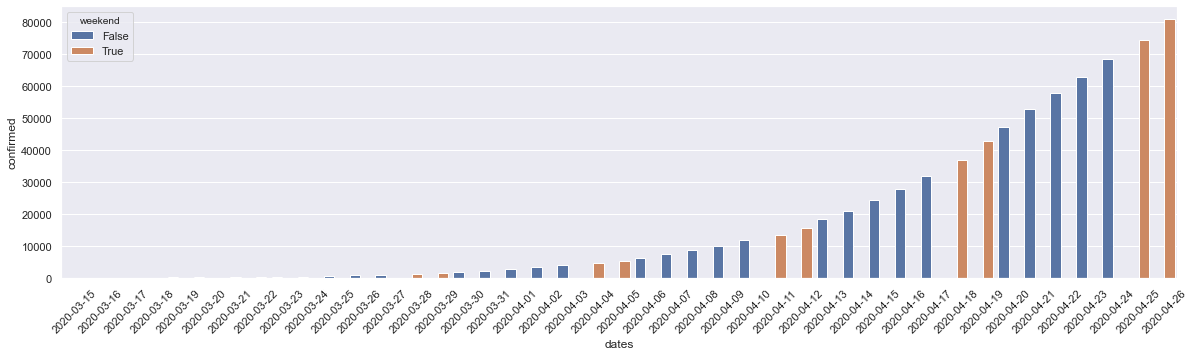

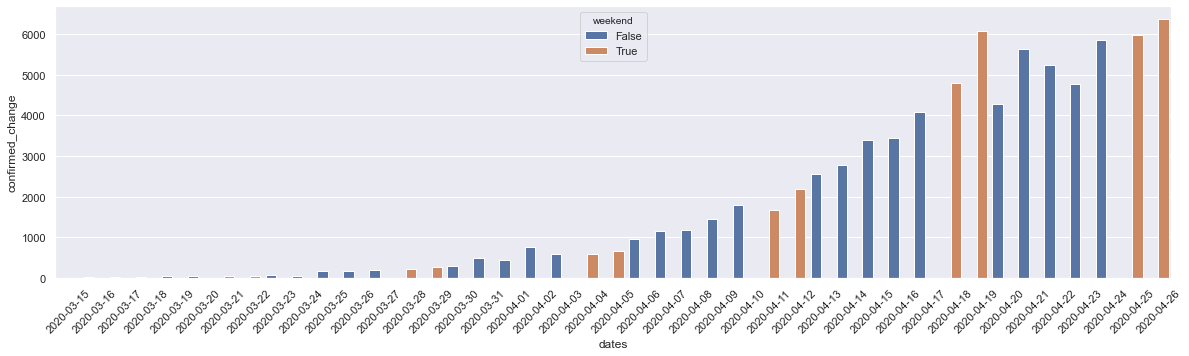

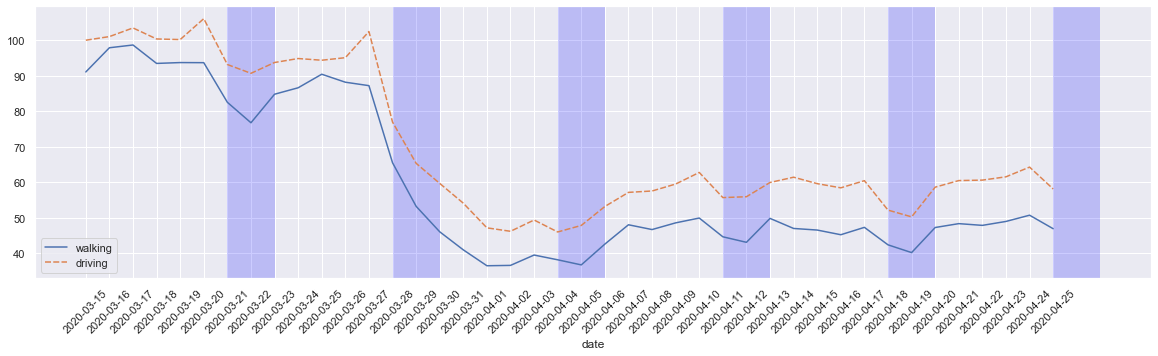

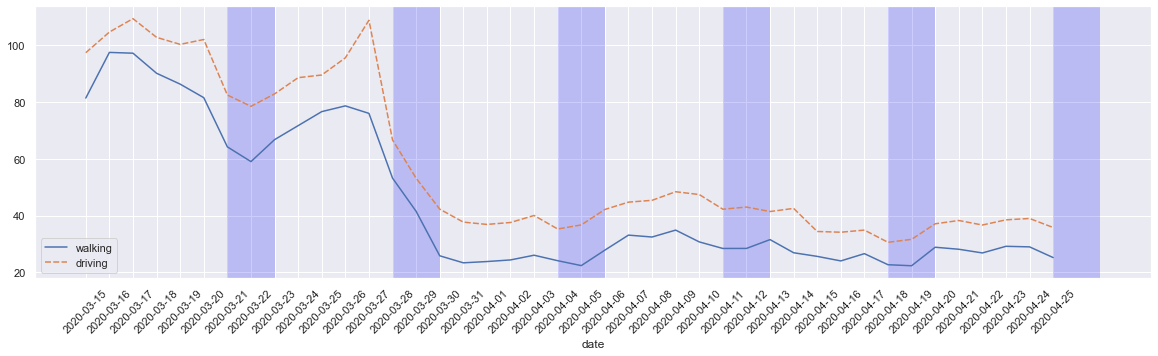

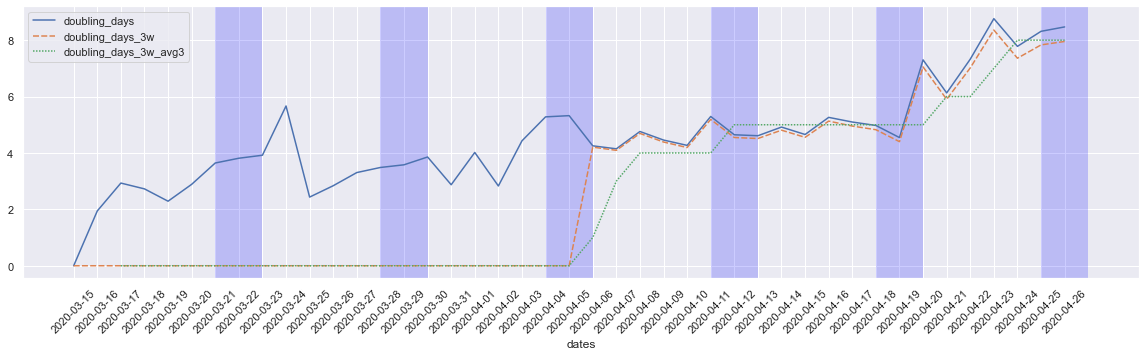

In [41]:
plot_bar(df_russia, columns='confirmed', date_cutoff='2020-03-15')
plot_bar(df_russia, columns='confirmed_change', date_cutoff='2020-03-15')
plot_line(apple_filter_region(dfapple, "Russia"), columns=['walking','driving'], date_cutoff='2020-03-15')
plot_line(apple_filter_region(dfapple, "Moscow"), columns=['walking','driving'], date_cutoff='2020-03-15')
# plot_line(df_russia, columns=['confirmed_change_pct', 'confirmed_change_pct_3w'], date_cutoff='2020-03-15')
plot_line(df_russia, columns=['doubling_days', 'doubling_days_3w', 'doubling_days_3w_avg3'], date_cutoff='2020-03-01')
# plot_line(df_russia, columns=['confirmed_change_acceleration_avg3'], date_cutoff='2020-03-01')

# Sweden

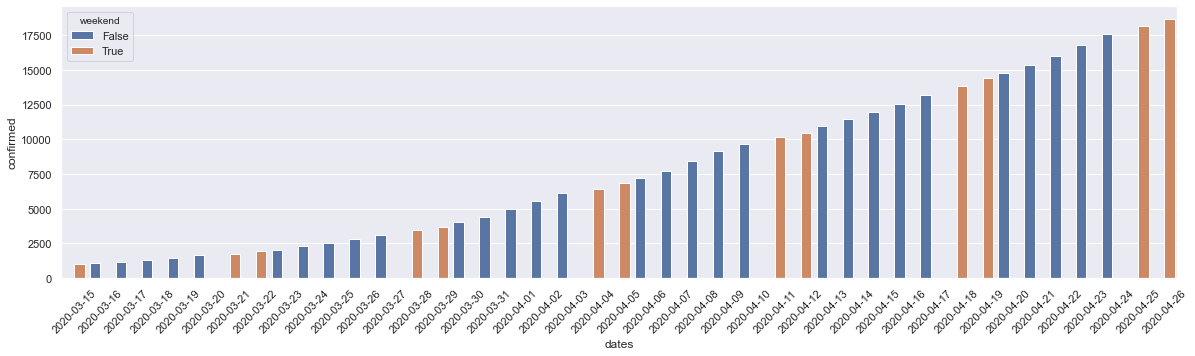

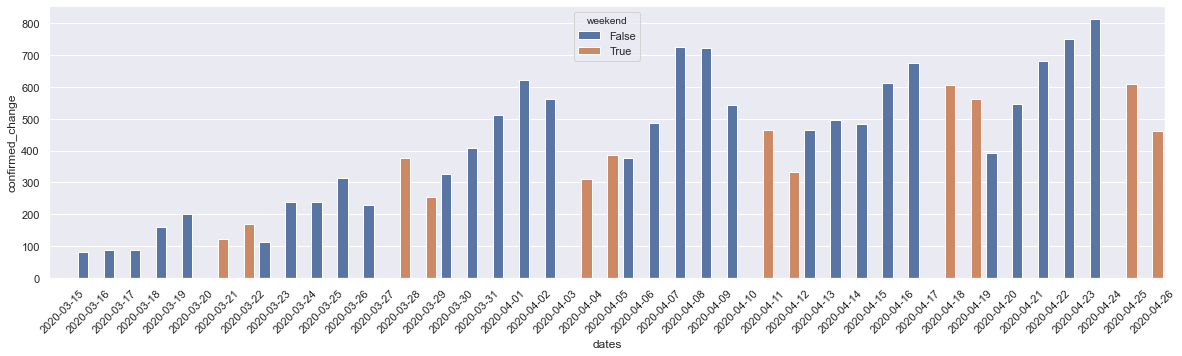

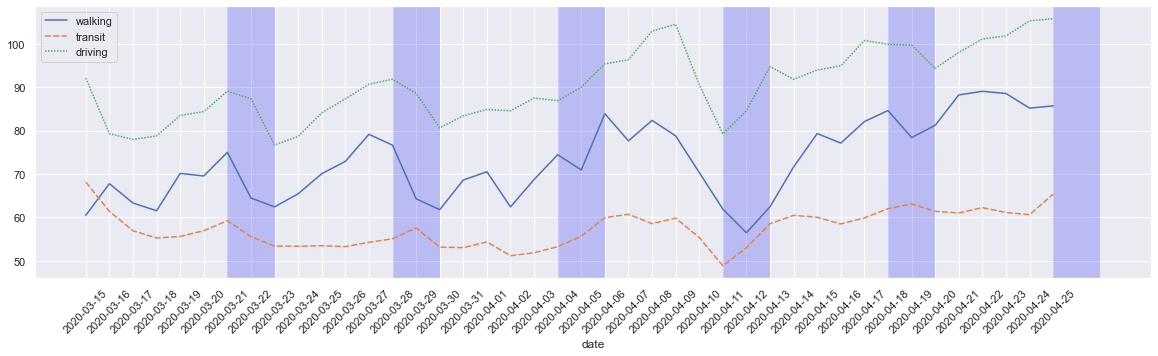

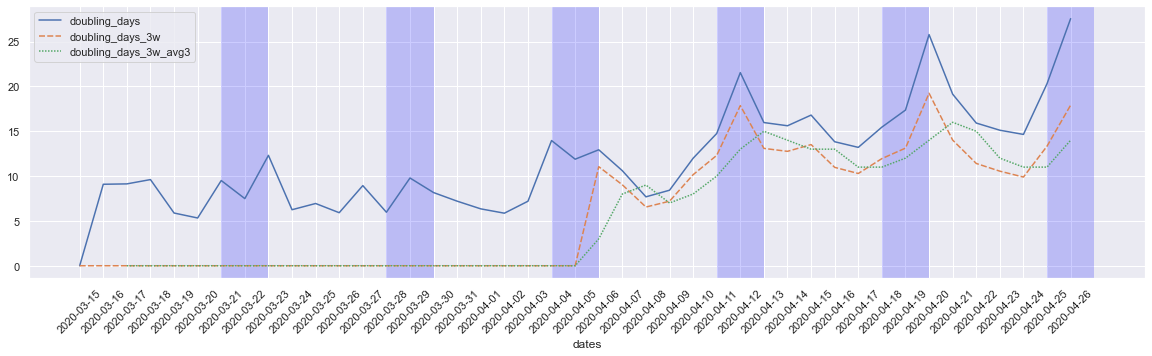

In [43]:
df_sweden = dfcovid_conf_t.loc[dfcovid_conf_t.index >= '2020-03-15', ['Sweden_nan']]
df_sweden.columns = ['confirmed']
df_sweden = add_variables_covid(df_sweden)

plot_bar(df_sweden, columns='confirmed', date_cutoff='2020-03-15')
plot_bar(df_sweden, columns='confirmed_change', date_cutoff='2020-03-15')
plot_line(apple_filter_region(dfapple, "Sweden"), columns=['walking', 'transit','driving'], date_cutoff='2020-03-15')
# plot_line(df_sweden, columns=['confirmed_change_pct', 'confirmed_change_pct_3w'], date_cutoff='2020-03-15')
plot_line(df_sweden, columns=['doubling_days', 'doubling_days_3w', 'doubling_days_3w_avg3'], date_cutoff='2020-03-01')
# plot_line(df_sweden, columns=['confirmed_change_acceleration_avg3'], date_cutoff='2020-03-01')

# UK

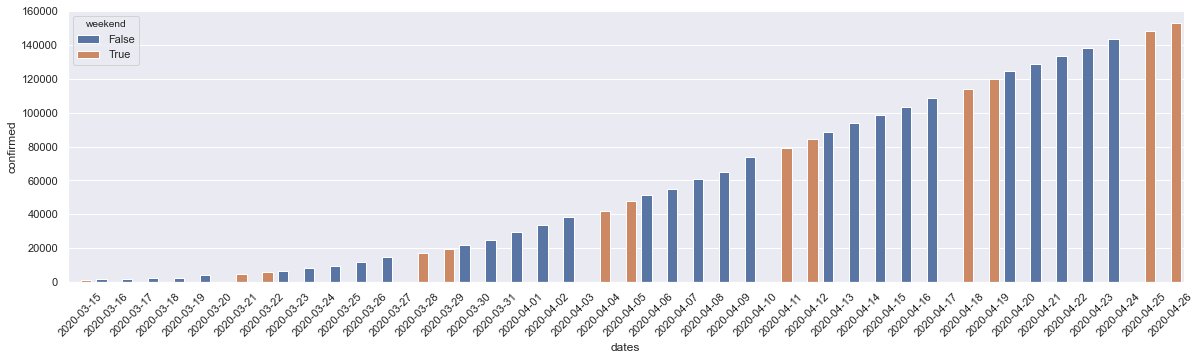

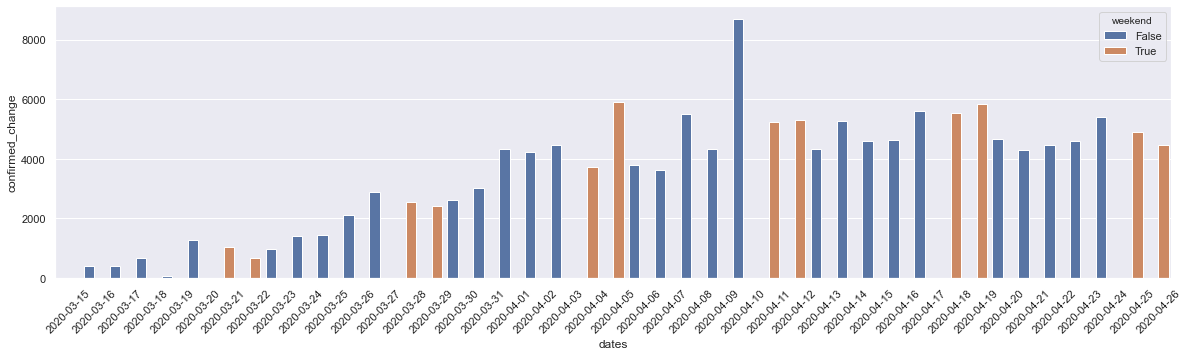

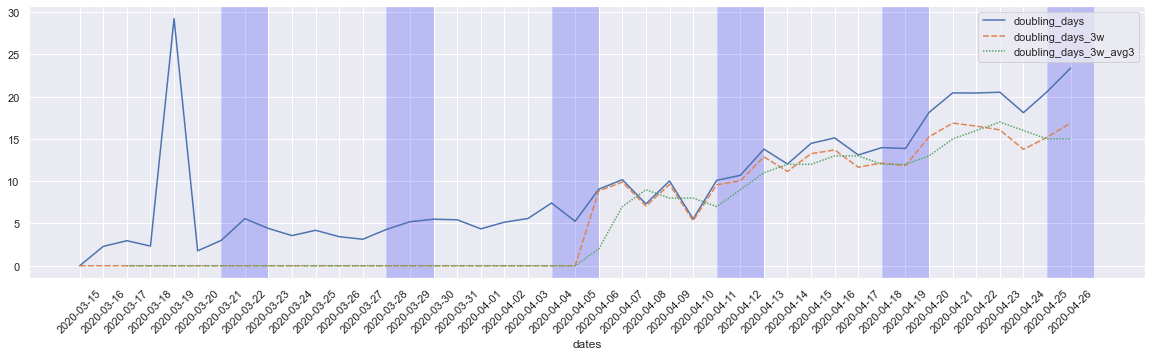

In [23]:
df_uk = dfcovid_conf_t.loc[dfcovid_conf_t.index >= '2020-03-15', ['United Kingdom_nan']]
df_uk.columns = ['confirmed']
df_uk = add_variables_covid(df_uk)

plot_bar(df_uk, columns='confirmed', date_cutoff='2020-03-15')
plot_bar(df_uk, columns='confirmed_change', date_cutoff='2020-03-15')
# plot_line(df_uk, columns=['confirmed_change_pct', 'confirmed_change_pct_3w'], date_cutoff='2020-03-15')
plot_line(df_uk, columns=['doubling_days', 'doubling_days_3w', 'doubling_days_3w_avg3'], date_cutoff='2020-03-01')
# plot_line(df_uk, columns=['confirmed_change_acceleration_avg3'], date_cutoff='2020-03-01')

# US

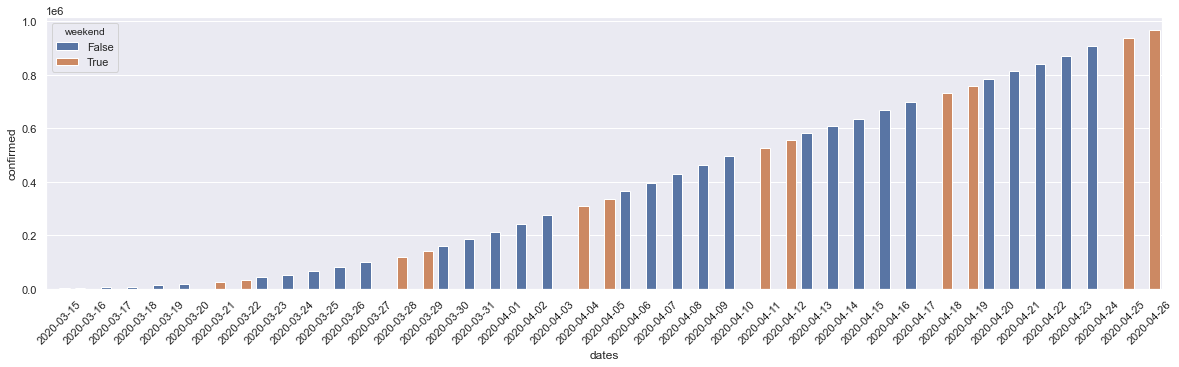

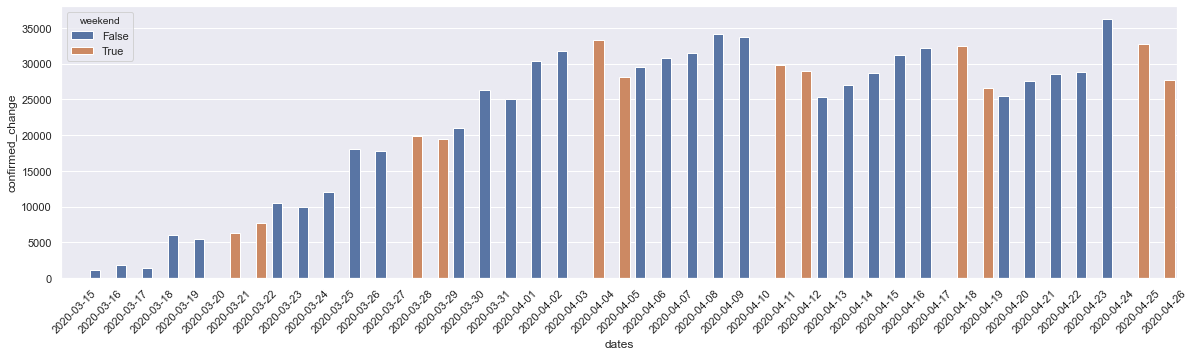

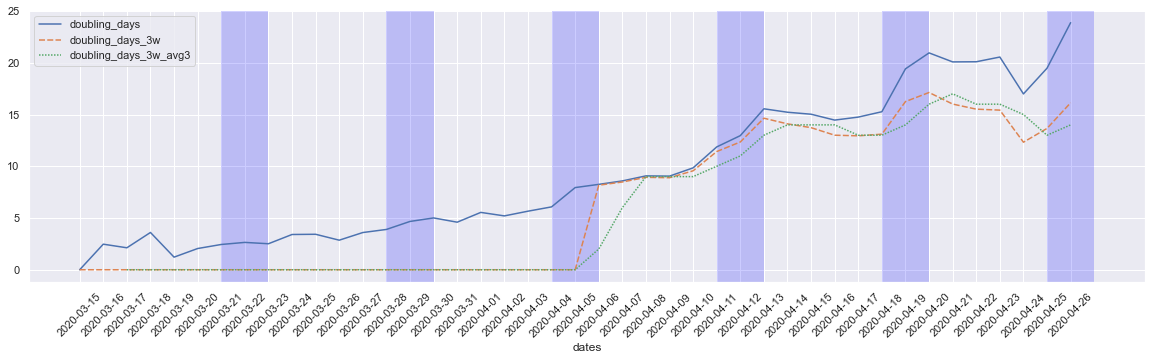

In [24]:
df_us = dfcovid_conf_t.loc[dfcovid_conf_t.index >= '2020-03-15', ['US_nan']]
df_us.columns = ['confirmed']
df_us = add_variables_covid(df_us)

plot_bar(df_us, columns='confirmed', date_cutoff='2020-03-15')
plot_bar(df_us, columns='confirmed_change', date_cutoff='2020-03-15')
# plot_line(df_uk, columns=['confirmed_change_pct', 'confirmed_change_pct_3w'], date_cutoff='2020-03-15')
plot_line(df_us, columns=['doubling_days', 'doubling_days_3w', 'doubling_days_3w_avg3'], date_cutoff='2020-03-01')
# plot_line(df_uk, columns=['confirmed_change_acceleration_avg3'], date_cutoff='2020-03-01')

## Join RKI and Mobility

In [25]:
df_joined = dfapple_region.join(df_hamburg)

In [44]:
# df_joined.loc['2020-03-18':'2020-03-30', ['change_%_conf','change_%_conf_avg3', 'transit', 'walking', 'driving']]

In [ ]:
dfcovid_conf.loc[dfcovid["Country/Region"] == 'Russia']